In [137]:
import os
import datasets 
from datasets import Dataset
from collections import defaultdict
import re
from torch.utils.data import DataLoader
from tqdm import tqdm


In [2]:
dataset_path = '/vision/u/eatang/ml_superb/eighth_version/'
languages = []

sources = os.listdir(dataset_path)

for source in sources:
    if source[0] != ".":
        languages.extend(os.listdir(os.path.join(dataset_path, source)))
        
languages = set([x for x in languages if '.' not in x])

In [3]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

language_to_paths = defaultdict(list)
language_to_sentences = defaultdict(list)
for language in languages:
    for source in sources:
        source_lang_path = os.path.join(dataset_path, source, language)
        if os.path.exists(source_lang_path):
            with open(os.path.join(source_lang_path, 'transcript_10min_test.txt'), 'r') as file:
                lines = [line.rstrip() for line in file]
                sentences = []
                paths = []
                for line in lines:
                    sentence = " ".join(re.split(r'[ \t]+', line)[2:])
                    sentence = remove_punctuation(sentence).lower().strip()
                    if len(sentence) <= 1:
                        continue
                    if len(re.split(r'[ \t]+', line)[0]) > 0:
                        sentences.append(sentence)
                        paths.append(os.path.join(source_lang_path, 'wav', re.split(r'[ \t]+', line)[0] + '.wav'))
            
                language_to_paths[language].extend(paths)
                language_to_sentences[language].extend(sentences)


In [4]:
# Get the number of examples for each language
language_example_counts = {language: len(sentences) for language, sentences in language_to_sentences.items()}

# Sort languages by the number of examples in descending order
languages_most_examples = sorted(language_example_counts, key=language_example_counts.get, reverse=True)[:10]

# Sort languages by the number of examples in ascending order
languages_least_examples = sorted(language_example_counts, key=language_example_counts.get)[:10]

# Output the results
print("Top 10 languages with most examples:", languages_most_examples)
print("Top 10 languages with least examples:", languages_least_examples)


Top 10 languages with most examples: ['eng', 'nld', 'deu', 'rus', 'fra', 'ita', 'gle', 'spa', 'ben', 'por']
Top 10 languages with least examples: ['umb', 'mri', 'lin', 'nya', 'ibo', 'fil', 'lug', 'oci', 'sna', 'mya']


In [77]:
languages

{'abk',
 'afr',
 'amh',
 'ara',
 'asm',
 'ast',
 'aze',
 'bak',
 'bas',
 'bel',
 'ben',
 'bos',
 'bre',
 'bul',
 'cat',
 'ceb',
 'ces',
 'chv',
 'ckb',
 'cmn',
 'cnh',
 'cym',
 'dan',
 'deu',
 'div',
 'ell',
 'eng',
 'epo',
 'est',
 'eus',
 'fas',
 'fil',
 'fin',
 'fra',
 'frr',
 'ful',
 'gle',
 'glg',
 'grn',
 'guj',
 'hau',
 'heb',
 'hin',
 'hrv',
 'hsb',
 'hun',
 'hye',
 'ibo',
 'ina',
 'ind',
 'isl',
 'ita',
 'jav',
 'jpn',
 'kab',
 'kam',
 'kan',
 'kat',
 'kaz',
 'kea',
 'khm',
 'kin',
 'kir',
 'kmr',
 'kor',
 'lao',
 'lav',
 'lga',
 'lin',
 'lit',
 'ltz',
 'lug',
 'luo',
 'mal',
 'mar',
 'mhr',
 'mkd',
 'mlt',
 'mon',
 'mri',
 'mrj',
 'msa',
 'mya',
 'myv',
 'nan',
 'nbl',
 'nep',
 'nld',
 'nno',
 'nob',
 'nso',
 'nya',
 'oci',
 'org_jpn',
 'ori',
 'orm',
 'ory',
 'pan',
 'pol',
 'por',
 'pus',
 'ron',
 'rus',
 'sah',
 'sin',
 'skr',
 'slk',
 'slv',
 'sna',
 'snd',
 'som',
 'sot',
 'spa',
 'srp',
 'ssw',
 'sun',
 'swa',
 'swe',
 'tam',
 'tat',
 'tel',
 'tgk',
 'tha',
 'tok',
 'to

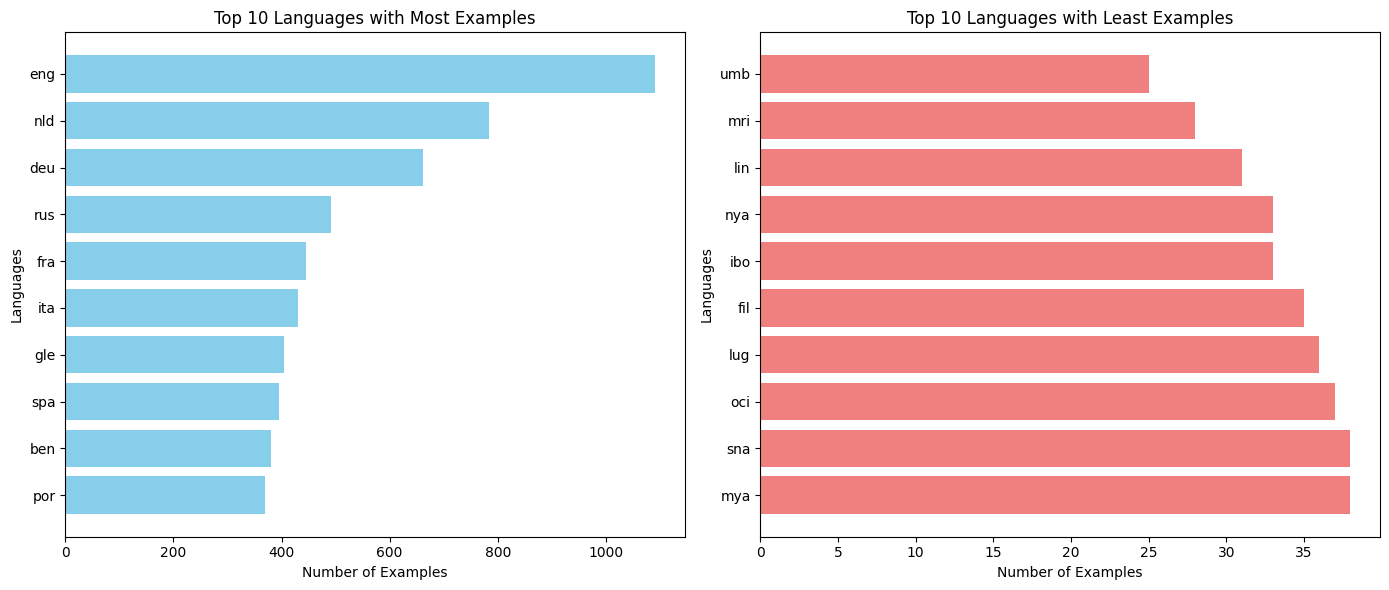

In [5]:
import matplotlib.pyplot as plt

# Assuming languages_most_examples and languages_least_examples are already defined as per the previous code

# Get the counts for the languages with most and least examples
counts_most_examples = [language_example_counts[lang] for lang in languages_most_examples]
counts_least_examples = [language_example_counts[lang] for lang in languages_least_examples]

# Plotting the bar chart for top 10 languages with most examples
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.barh(languages_most_examples, counts_most_examples, color='skyblue')
plt.xlabel('Number of Examples')
plt.ylabel('Languages')
plt.title('Top 10 Languages with Most Examples')
plt.gca().invert_yaxis()  # Invert y-axis to show the largest at the top

# Plotting the bar chart for top 10 languages with least examples
plt.subplot(1, 2, 2)
plt.barh(languages_least_examples, counts_least_examples, color='lightcoral')
plt.xlabel('Number of Examples')
plt.ylabel('Languages')
plt.title('Top 10 Languages with Least Examples')
plt.gca().invert_yaxis()  # Invert y-axis to show the smallest at the top

# Show the plot
plt.tight_layout()
plt.show()


In [135]:
from transformers import WhisperProcessor,WhisperForConditionalGeneration, Wav2Vec2Processor, Wav2Vec2ForCTC
import torchaudio
from datasets import Dataset
import torch
import os
import numpy as np
from jiwer import wer

# Function to load and preprocess audio files
def load_audio(path):
    speech, _ = torchaudio.load(path)
    return speech.squeeze().numpy()

# Preprocess the dataset
def preprocess(batch):
    audio = [load_audio(path) for path in batch["audio"]]
    inputs = processor(audio, sampling_rate=16000, return_tensors="pt").to("cuda")
    labels = processor.tokenizer(text=batch["sentence"], return_tensors="pt", padding=True).input_ids
    inputs["labels"] = labels.to("cuda")
    return inputs

# Function to decode model predictions
def decode_predictions(pred_ids):
    pred_ids = pred_ids.cpu().numpy()
    pred_str = processor.batch_decode(pred_ids)
    return pred_str

# Evaluate WER
def compute_wer(batch, language=LANG):
    inputs = {key: batch[key].to("cuda") for key in batch if key != "audio" and key != "sentence"}

    with torch.no_grad():
        pred_ids = model.generate(inputs["input_features"], language=language)
    
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    pred_str = [remove_punctuation(x).lower().strip() for x in pred_str]
    label_str = processor.batch_decode(batch["labels"].cpu().numpy(), skip_special_tokens=True)
    
    wer_score = wer(label_str, pred_str)
    return wer_score




In [142]:
LANG = "swahili"
MODEL_ID = "openai/whisper-small"
processor = WhisperProcessor.from_pretrained(MODEL_ID, language=LANG)
model = WhisperForConditionalGeneration.from_pretrained(MODEL_ID).to("cuda")

languages = ['bas', 'kin', 'lug', 'nso', 'nya', 'ssw', 'swa', 'tsn', 'ven', 'xho', 'zul']

for language in languages:
    # Prepare the data for Hugging Face datasets
    data = {
        "audio": [],
        "sentence": []
    }

    for path, sentence in zip(language_to_paths[language], language_to_sentences[language]):
        data["audio"].append(path)
        data["sentence"].append(sentence)

    
    dataset = Dataset.from_dict(data)


    train_set = dataset.map(preprocess, batched=True, batch_size=32).with_format("torch")
    dataloader = DataLoader(train_set, batch_size=32)
    
    
    model.generation_config.language = LANG
    model.generation_config.task = "transcribe"
    model.generation_config.forced_decoder_ids = None

    # Compute WER for the entire dataset
    wer_scores = []

    # Use tqdm to wrap your dataloader to show a progress bar
    for batch in tqdm(dataloader, desc="Processing batches"):
        wer_scores.append(compute_wer(batch))

    average_wer = np.mean(wer_scores)
    print(f"{language} Average WER: {average_wer}")

Map:   0%|          | 0/148 [00:00<?, ? examples/s]

Processing batches: 100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.92s/it]


bas Average WER: 1.5414070517480047


Map:   0%|          | 0/117 [00:00<?, ? examples/s]

Processing batches: 100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:27<00:00,  6.82s/it]


kin Average WER: 4.701485640753473


Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Processing batches: 100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:12<00:00,  6.29s/it]


lug Average WER: 1.3577344625731724


Map:   0%|          | 0/213 [00:00<?, ? examples/s]

Processing batches: 100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:01<00:00,  8.73s/it]


nso Average WER: 1.7320920305648644


Map:   0%|          | 0/33 [00:00<?, ? examples/s]

Processing batches: 100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.37s/it]


nya Average WER: 1.5878550074738413


Map:   0%|          | 0/116 [00:00<?, ? examples/s]

Processing batches: 100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.00s/it]


ssw Average WER: 1.8960886916466055


Map:   0%|          | 0/317 [00:00<?, ? examples/s]

Processing batches: 100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.41s/it]


swa Average WER: 1.3677290711241297


Map:   0%|          | 0/286 [00:00<?, ? examples/s]

Processing batches: 100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:56<00:00,  6.26s/it]


tsn Average WER: 3.2601825141541503


Map:   0%|          | 0/147 [00:00<?, ? examples/s]

Processing batches: 100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.54s/it]


ven Average WER: 0.9251800321355536


Map:   0%|          | 0/314 [00:00<?, ? examples/s]

Processing batches: 100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:03<00:00,  6.37s/it]


xho Average WER: 3.5466739240322314


Map:   0%|          | 0/175 [00:00<?, ? examples/s]

Processing batches: 100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:27<00:00,  4.54s/it]

zul Average WER: 2.310262811394558


Average WER: 2.3419111637460106


In [106]:
for batch in dataloader:
    inputs = {key: batch[key].to("cuda") for key in batch if key != "audio" and key != "sentence"}
    model.generation_config.language = "swahili"
    model.generation_config.task = "transcribe"


    with torch.no_grad():
        pred_ids = model.generate(inputs["input_features"], language="swahili", )

    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    pred_str = [remove_punctuation(x).lower().strip() for x in pred_str]
    label_str = processor.batch_decode(batch["labels"].cpu().numpy(), skip_special_tokens=True)

    wer_score = wer(label_str, pred_str)
    break

In [131]:
i = 6

In [132]:
pred_str[i]

'mbunji inum blonganjin'

In [133]:
label_str[i]

'mbônji i nnumb loñge njiñ'

In [134]:
wer([label_str[i]], [pred_str[i]])

1.0